In [1]:
import datetime
tokens = ['ADA', 'BNB', 'BTC', 'DOGE', 'ETH', 'MATIC', 'SOL', 'USDC', 'USDT', 'XRP'] #remove 'BTC', 'ETH' and 'USDT' and compare portfolios
tokens_USD = [token + '-USD' for token in tokens]
period = 7
start = datetime.datetime.strptime('2023-03-13', '%Y-%m-%d').date() #optimizing portfolio on a start day, predicting on a (start+1, start+period)
end = start + datetime.timedelta(days=period)

### Firstly, we need to get real token prices using Messari API. ##

In [2]:
from messari.messari import Messari
messari = Messari()
prices = messari.get_metric_timeseries(asset_slugs=tokens, asset_metric='price', start=start, end=end)
dates = prices.reset_index()['timestamp'].tolist()

In [3]:
import pandas as pd
prices_df = pd.DataFrame()
for token in tokens:
    prices_df[token] = prices[token]['close'].tolist()
prices_df

,ADA,BNB,BTC,DOGE,ETH,MATIC,SOL,USDC,USDT,XRP
0,0.344707,309.037835,24201.313033,0.073067,1680.106838,1.197265,20.475878,0.998732,1.003743,0.373708
1,0.344196,309.406623,24748.607678,0.074806,1704.841797,1.200376,20.930100,0.999697,1.003197,0.373580
2,0.325316,307.385006,24375.154682,0.069904,1656.087950,1.115695,19.315910,0.999836,1.003524,0.360229
3,0.325512,330.082351,25049.758100,0.072695,1676.994728,1.150136,19.715195,1.000018,1.002223,0.365421
4,0.350152,339.606220,27450.035332,0.076585,1793.045081,1.225301,21.645166,0.997578,1.000588,0.380582
5,0.337970,331.878128,26975.547964,0.073133,1763.320266,1.173391,21.257806,1.002080,1.004163,0.374817
6,0.345772,337.618311,28053.113651,0.074717,1785.852108,1.169611,21.918982,1.006397,1.006847,0.386843
7,0.332995,333.301814,27787.823446,0.071553,1737.173526,1.105395,22.187841,0.998547,1.001766,0.374365


In [4]:
start_prices = prices_df.loc[0].to_dict()
prices_df = prices_df.drop(0)
start_prices

{'ADA': 0.3447071199926446,
 'BNB': 309.0378351390478,
 'BTC': 24201.31303270494,
 'DOGE': 0.07306749469972572,
 'ETH': 1680.1068379797898,
 'MATIC': 1.197264867202163,
 'SOL': 20.475877977975276,
 'USDC': 0.9987315109459727,
 'USDT': 1.003742670379996,
 'XRP': 0.37370761873202396}

### Then let's make predictions with our ARIMA model. ###

In [5]:
from src.make_prediction import make_predict

start_learning = datetime.datetime(year=start.year-3, month=start.month, day=start.day).date()
end_learning = start
views = {}
for token in tokens:
    prediction = make_predict(token, start=start_learning, end=end_learning, period=period)
    views[token + '-USD'] = prediction
views

{'ADA-USD': -0.01694077358507712,
 'BNB-USD': 0.011680221255861597,
 'BTC-USD': 0.003016213738729243,
 'DOGE-USD': 0.022521034674211855,
 'ETH-USD': 0.007826916587910298,
 'MATIC-USD': -0.0060478395092812475,
 'SOL-USD': 0.006097009369579579,
 'USDC-USD': 0.00131536231407951,
 'USDT-USD': -0.003399422440685469,
 'XRP-USD': 0.0014181933255701504}

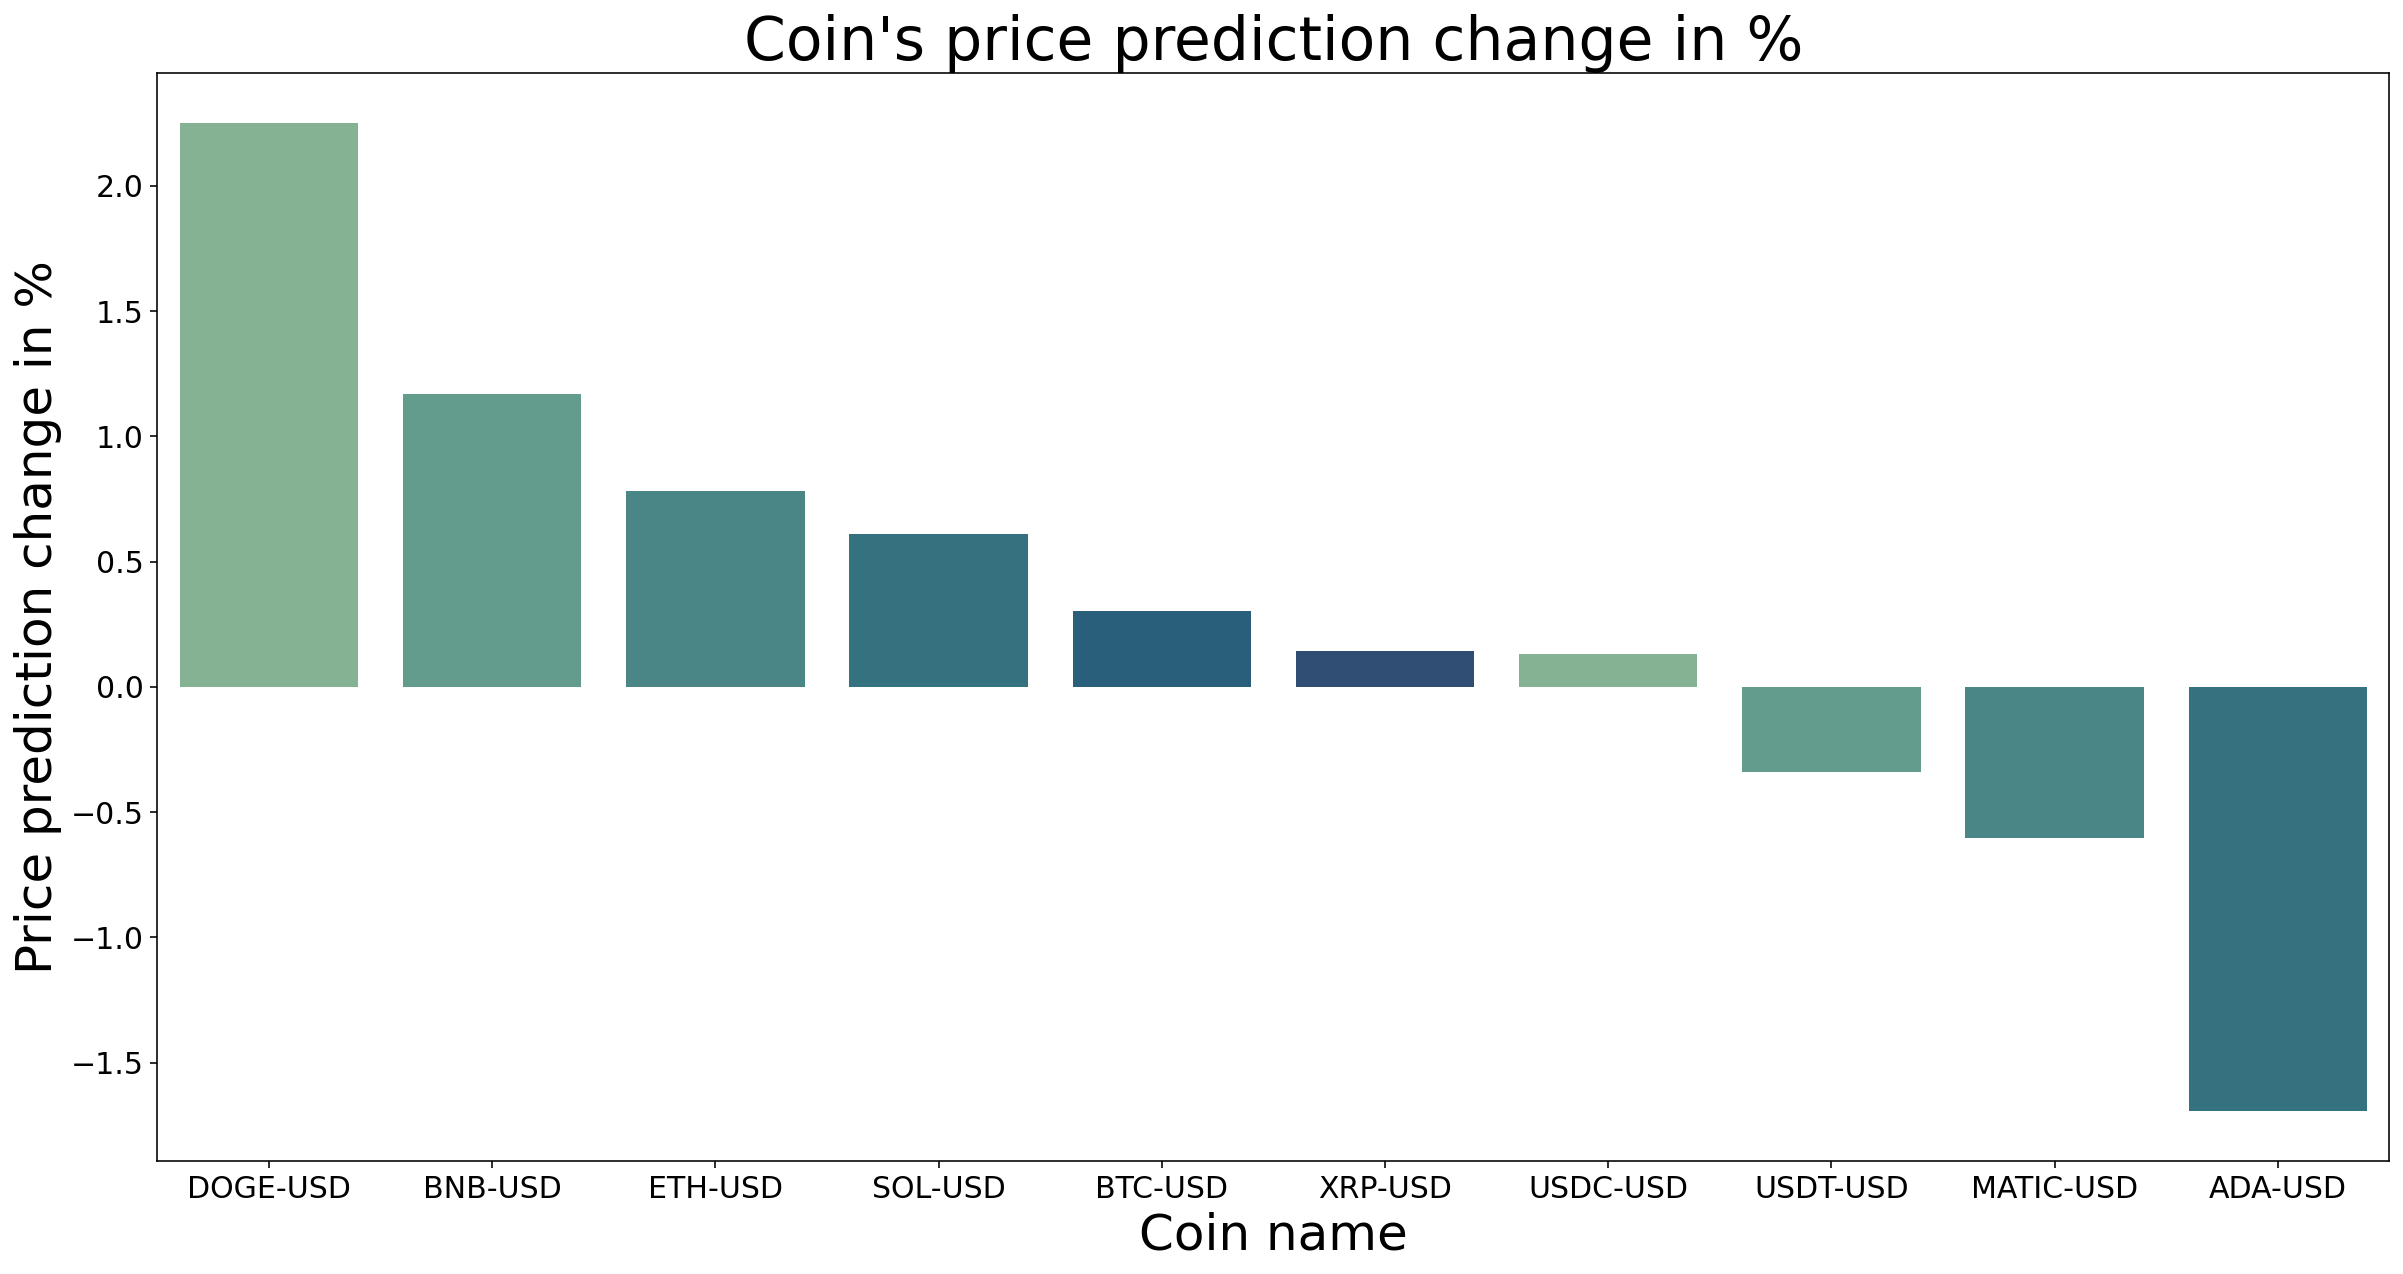

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

views_df = pd.DataFrame(views.items(), columns=['Coin', 'Prediction'])
views_df['Prediction'] *= 100
views_df = views_df.sort_values(by=['Prediction'], ascending=False)

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10
sns.barplot(data=views_df, x='Coin', y='Prediction', palette=sns.color_palette("crest"))
plt.xlabel("Coin name", fontsize = 25)
plt.ylabel("Price prediction change in %", fontsize = 25)
plt.title("Coin's price prediction change in %", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [7]:
import yfinance
market_caps = {}

for token in tokens_USD:
    t = yfinance.Ticker(token)
    market_caps[token] = t.info['marketCap']
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['Coin', 'Market_cap'])
market_caps_df

,Coin,Market_cap
0,ADA-USD,12795874304
1,BNB-USD,48147017728
2,BTC-USD,518523453440
3,DOGE-USD,10246381568
4,ETH-USD,216047632384
5,MATIC-USD,7912248832
6,SOL-USD,8157856768
7,USDC-USD,29593909248
8,USDT-USD,82839511040
9,XRP-USD,22809524224


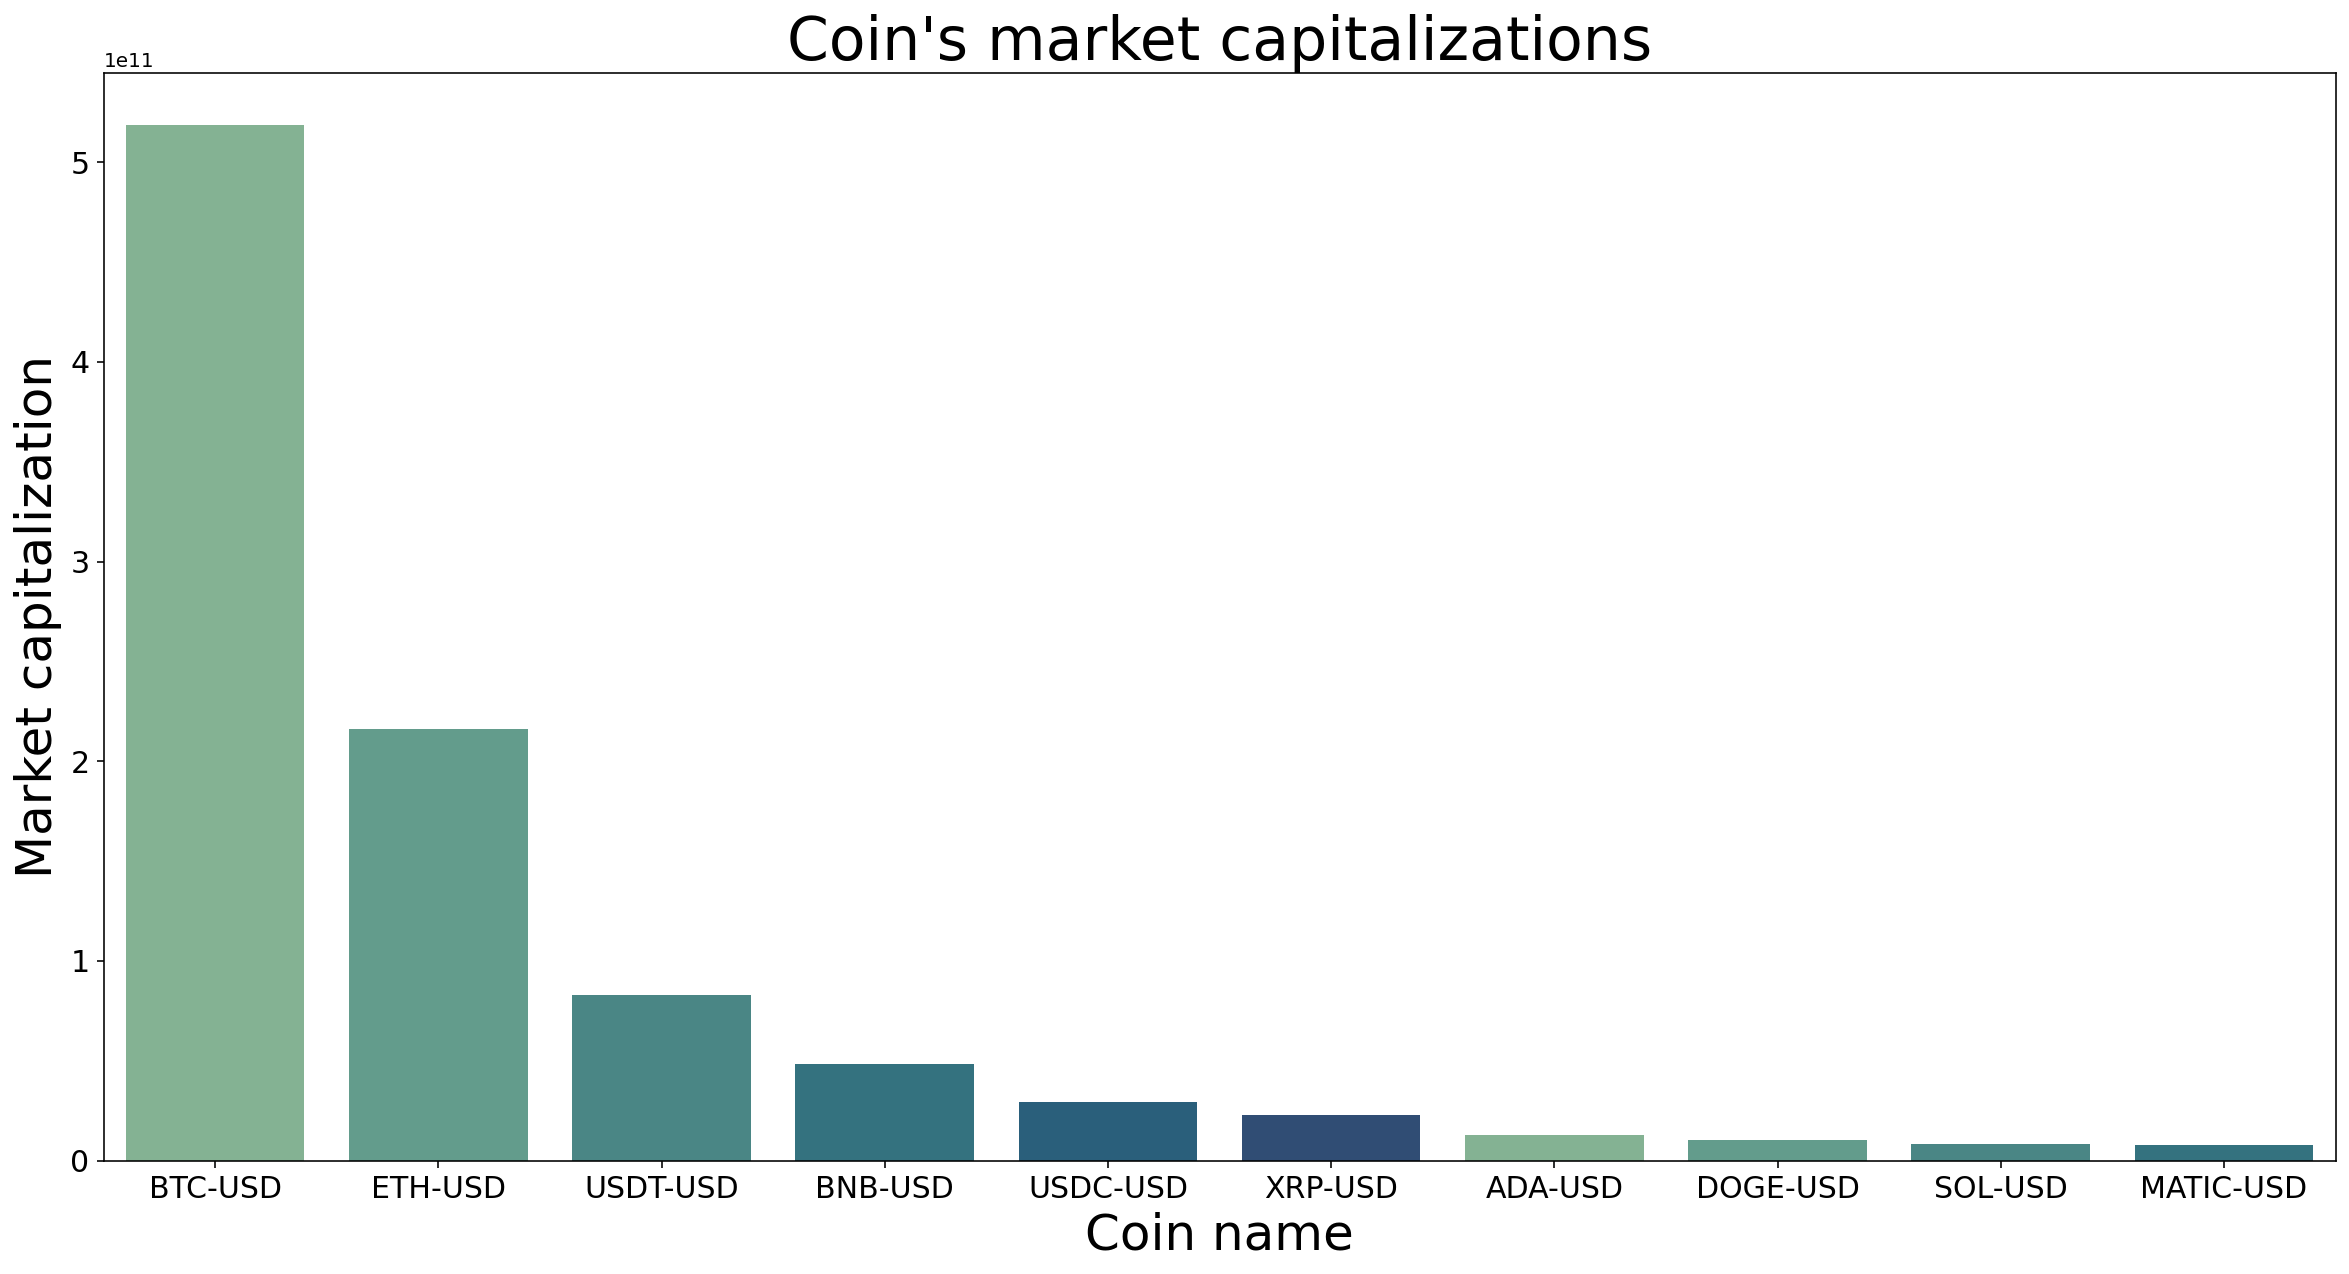

In [8]:
market_caps_df = market_caps_df.sort_values(by='Market_cap', ascending=False)
sns.barplot(data=market_caps_df, x='Coin', y='Market_cap', palette=sns.color_palette("crest"))
plt.xlabel("Coin name", fontsize = 25)
plt.ylabel("Market capitalization", fontsize = 25)
plt.title("Coin's market capitalizations", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

### Now let's try to optimize our portfolio. ###

In [9]:
from src.make_portfolio import optimize_portfolio

weights = optimize_portfolio(tokens=tokens_USD, views=views)
weights_dict = weights.to_dict()[0]
weights_df = pd.DataFrame(weights_dict.items(), columns=['Coin', 'Weight'])
weights_df

,Coin,Weight
0,ADA-USD,0.000000
1,BNB-USD,0.027357
2,BTC-USD,0.635808
3,DOGE-USD,0.012547
4,ETH-USD,0.274021
5,MATIC-USD,0.000000
6,SOL-USD,0.000000
7,USDC-USD,0.001596
8,USDT-USD,0.048670
9,XRP-USD,0.000000


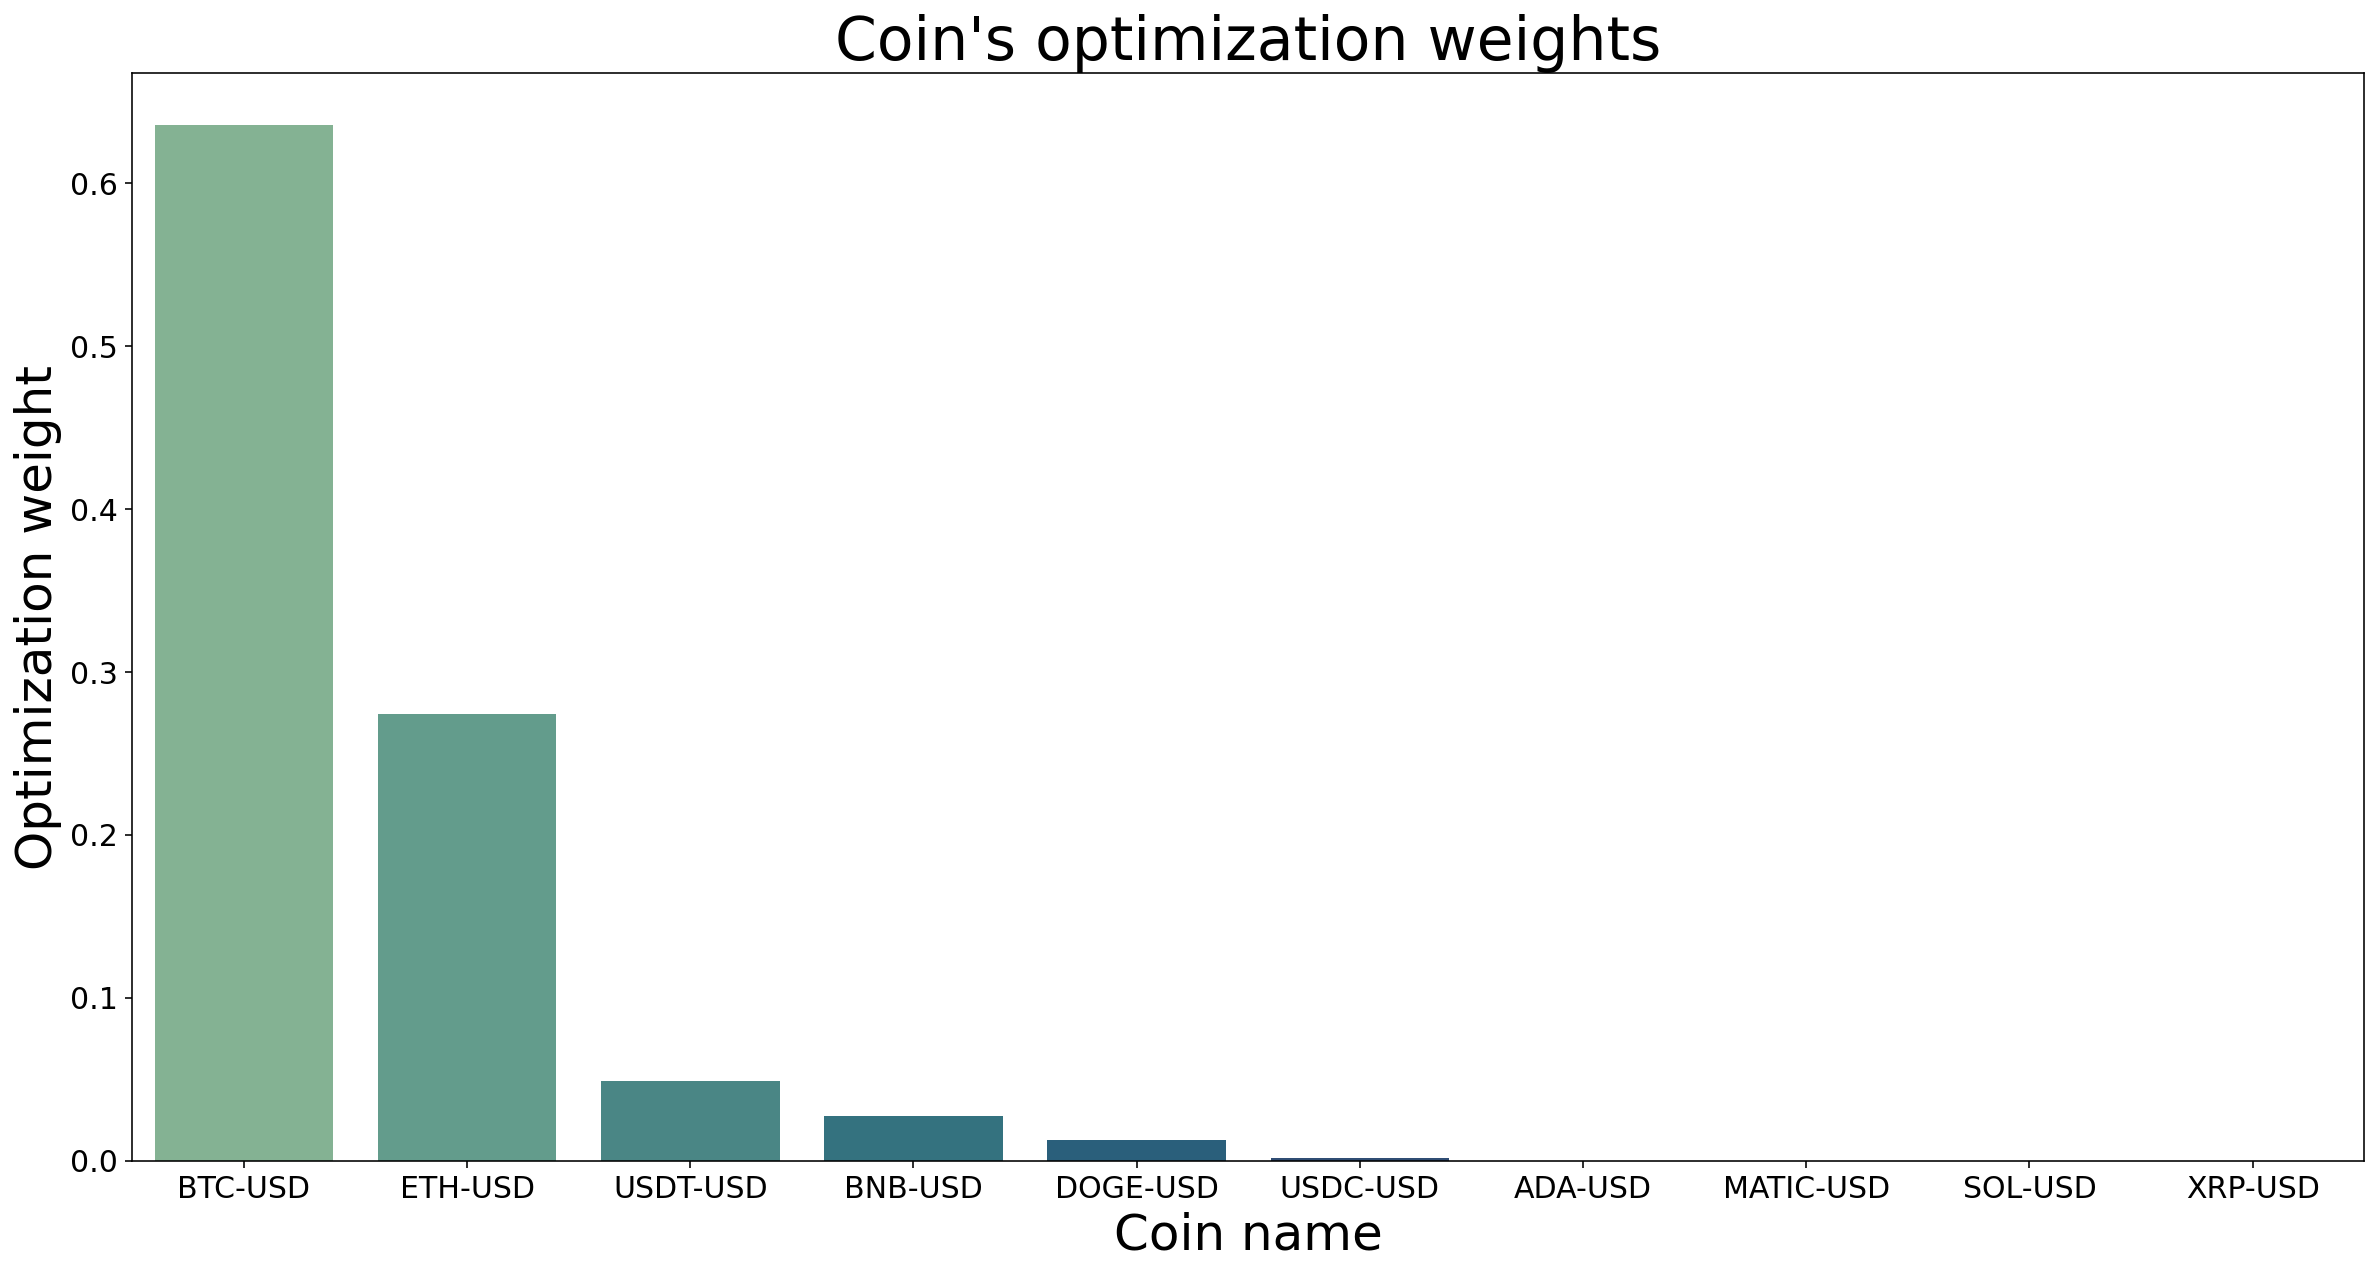

In [10]:
weights_df = weights_df.sort_values(by=['Weight'], ascending=False)
sns.barplot(data=weights_df, x='Coin', y='Weight', palette=sns.color_palette("crest"))
plt.xlabel("Coin name", fontsize = 25)
plt.ylabel("Optimization weight", fontsize = 25)
plt.title("Coin's optimization weights", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

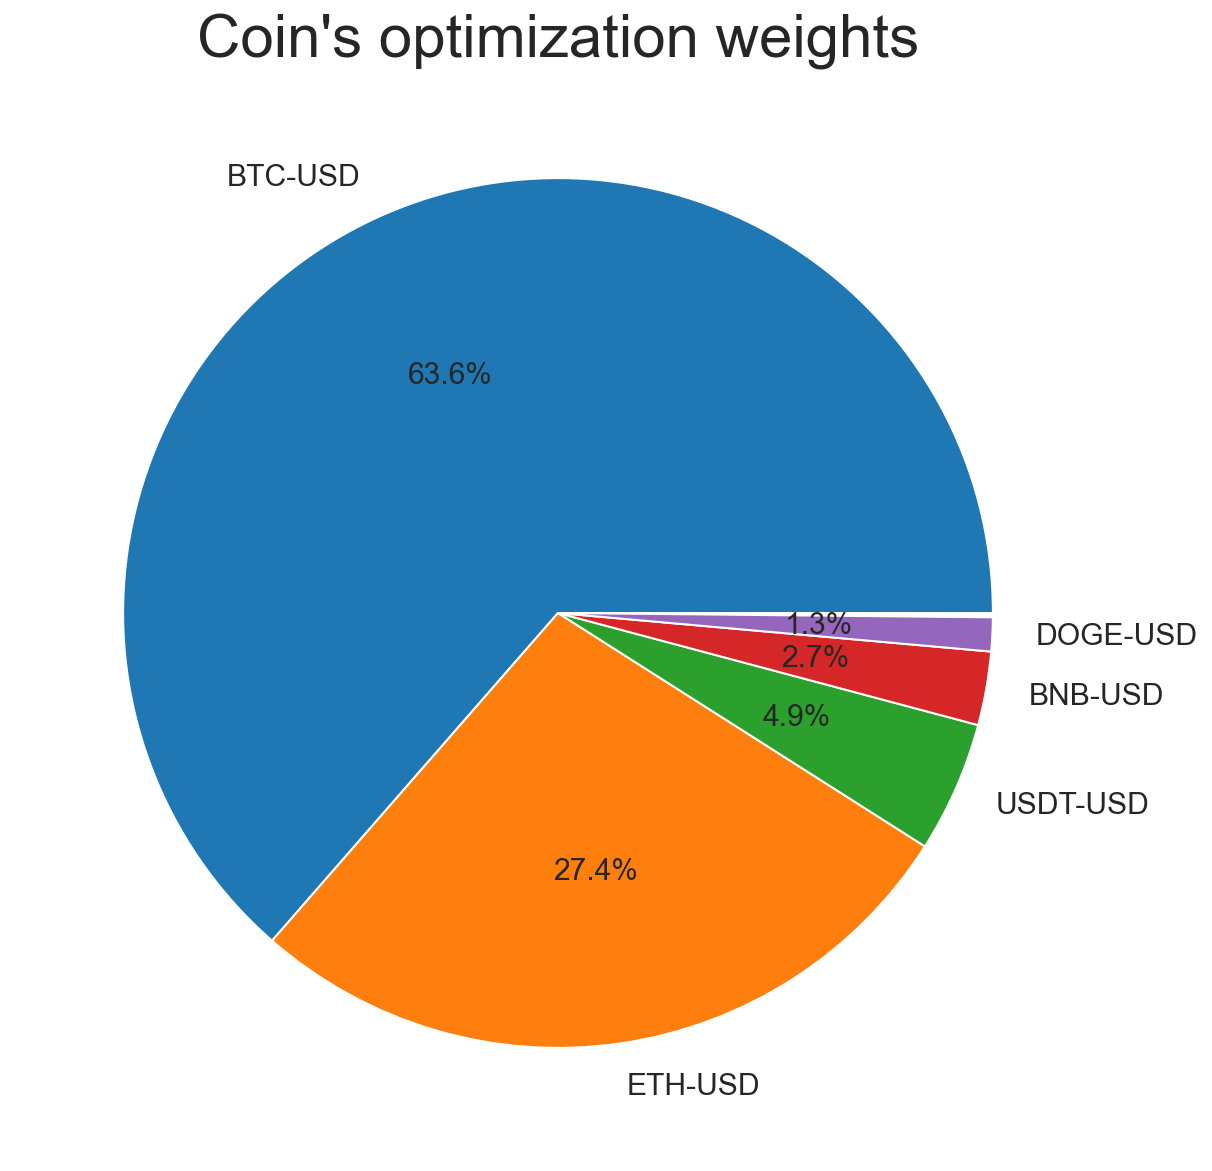

In [11]:
sns.set_style(style='white')
plt.pie(data=weights_df[weights_df['Weight'] > 0.01], x = 'Weight', labels ='Coin', autopct='%1.1f%%', textprops={'fontsize':15})
plt.title("Coin's optimization weights", fontsize = 30)
plt.show()

### Let's calculate the profit. ###

In [12]:
start_portfolio_value = 10000
portfolio_values = [start_portfolio_value]
today_value = 0
for _, row in prices_df.iterrows():
    for token in tokens:
        today_value += row[token] * (weights_dict[token + '-USD'] * start_portfolio_value / start_prices[token])
    portfolio_values.append(today_value)
    today_value = 0

final_portfolio_value = portfolio_values[-1]
portfolio_change = (final_portfolio_value - start_portfolio_value)
relative_portfolio_change = portfolio_change / start_portfolio_value * 100
print("Final portfolio value = %.3f" % final_portfolio_value, sep="")
print("Final portfolio change = %.3f" % portfolio_change, sep="")
print("Relative porfolio change = %.3f" % relative_portfolio_change , '%', sep ="")

Final portfolio value = 11053.226
Final portfolio change = 1053.226
Relative porfolio change = 10.532%


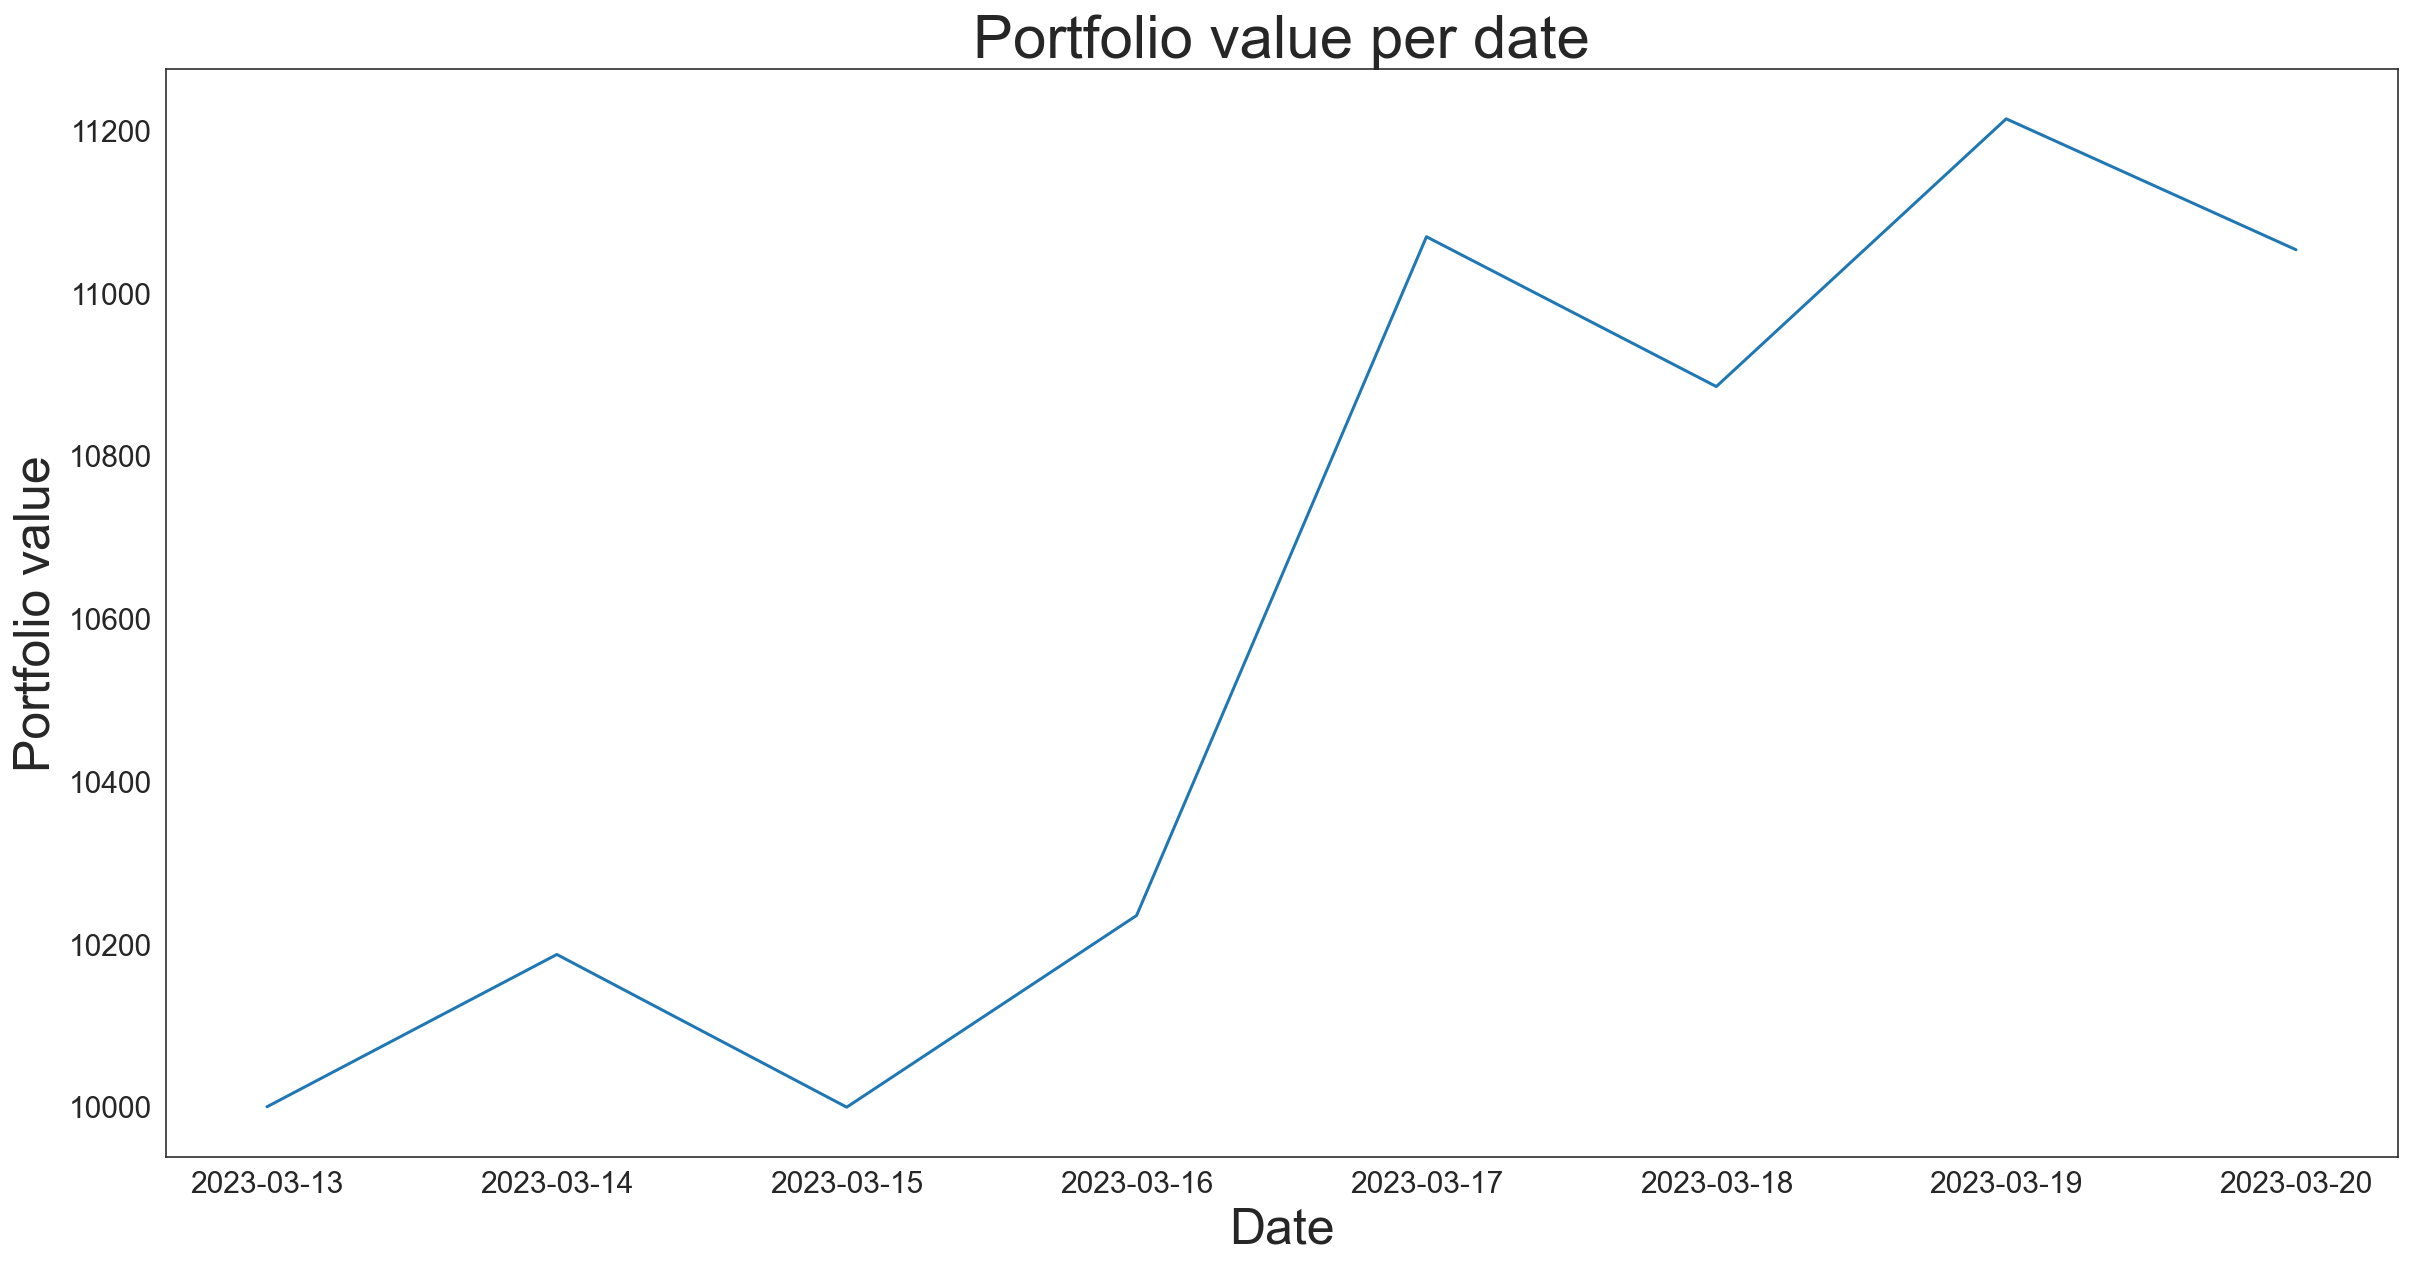

In [13]:
plt.plot(dates, portfolio_values)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Portfolio value", fontsize = 25)
plt.title("Portfolio value per date", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

### Now let's build random portfolios. ###

In [14]:
import numpy as np
np.random.seed(42)
random_weights = np.random.rand(len(tokens))
random_weights /= random_weights.sum()
random_weights = list(map(lambda x: np.round(x, 5), random_weights))
random_weights_dict = {}
i = 0
for token in tokens_USD:
    random_weights_dict[token] = random_weights[i]
    i += 1
random_weights_dict

{'ADA-USD': 0.07201,
 'BNB-USD': 0.18278,
 'BTC-USD': 0.14073,
 'DOGE-USD': 0.1151,
 'ETH-USD': 0.03,
 'MATIC-USD': 0.02999,
 'SOL-USD': 0.01117,
 'USDC-USD': 0.16653,
 'USDT-USD': 0.11557,
 'XRP-USD': 0.13613}

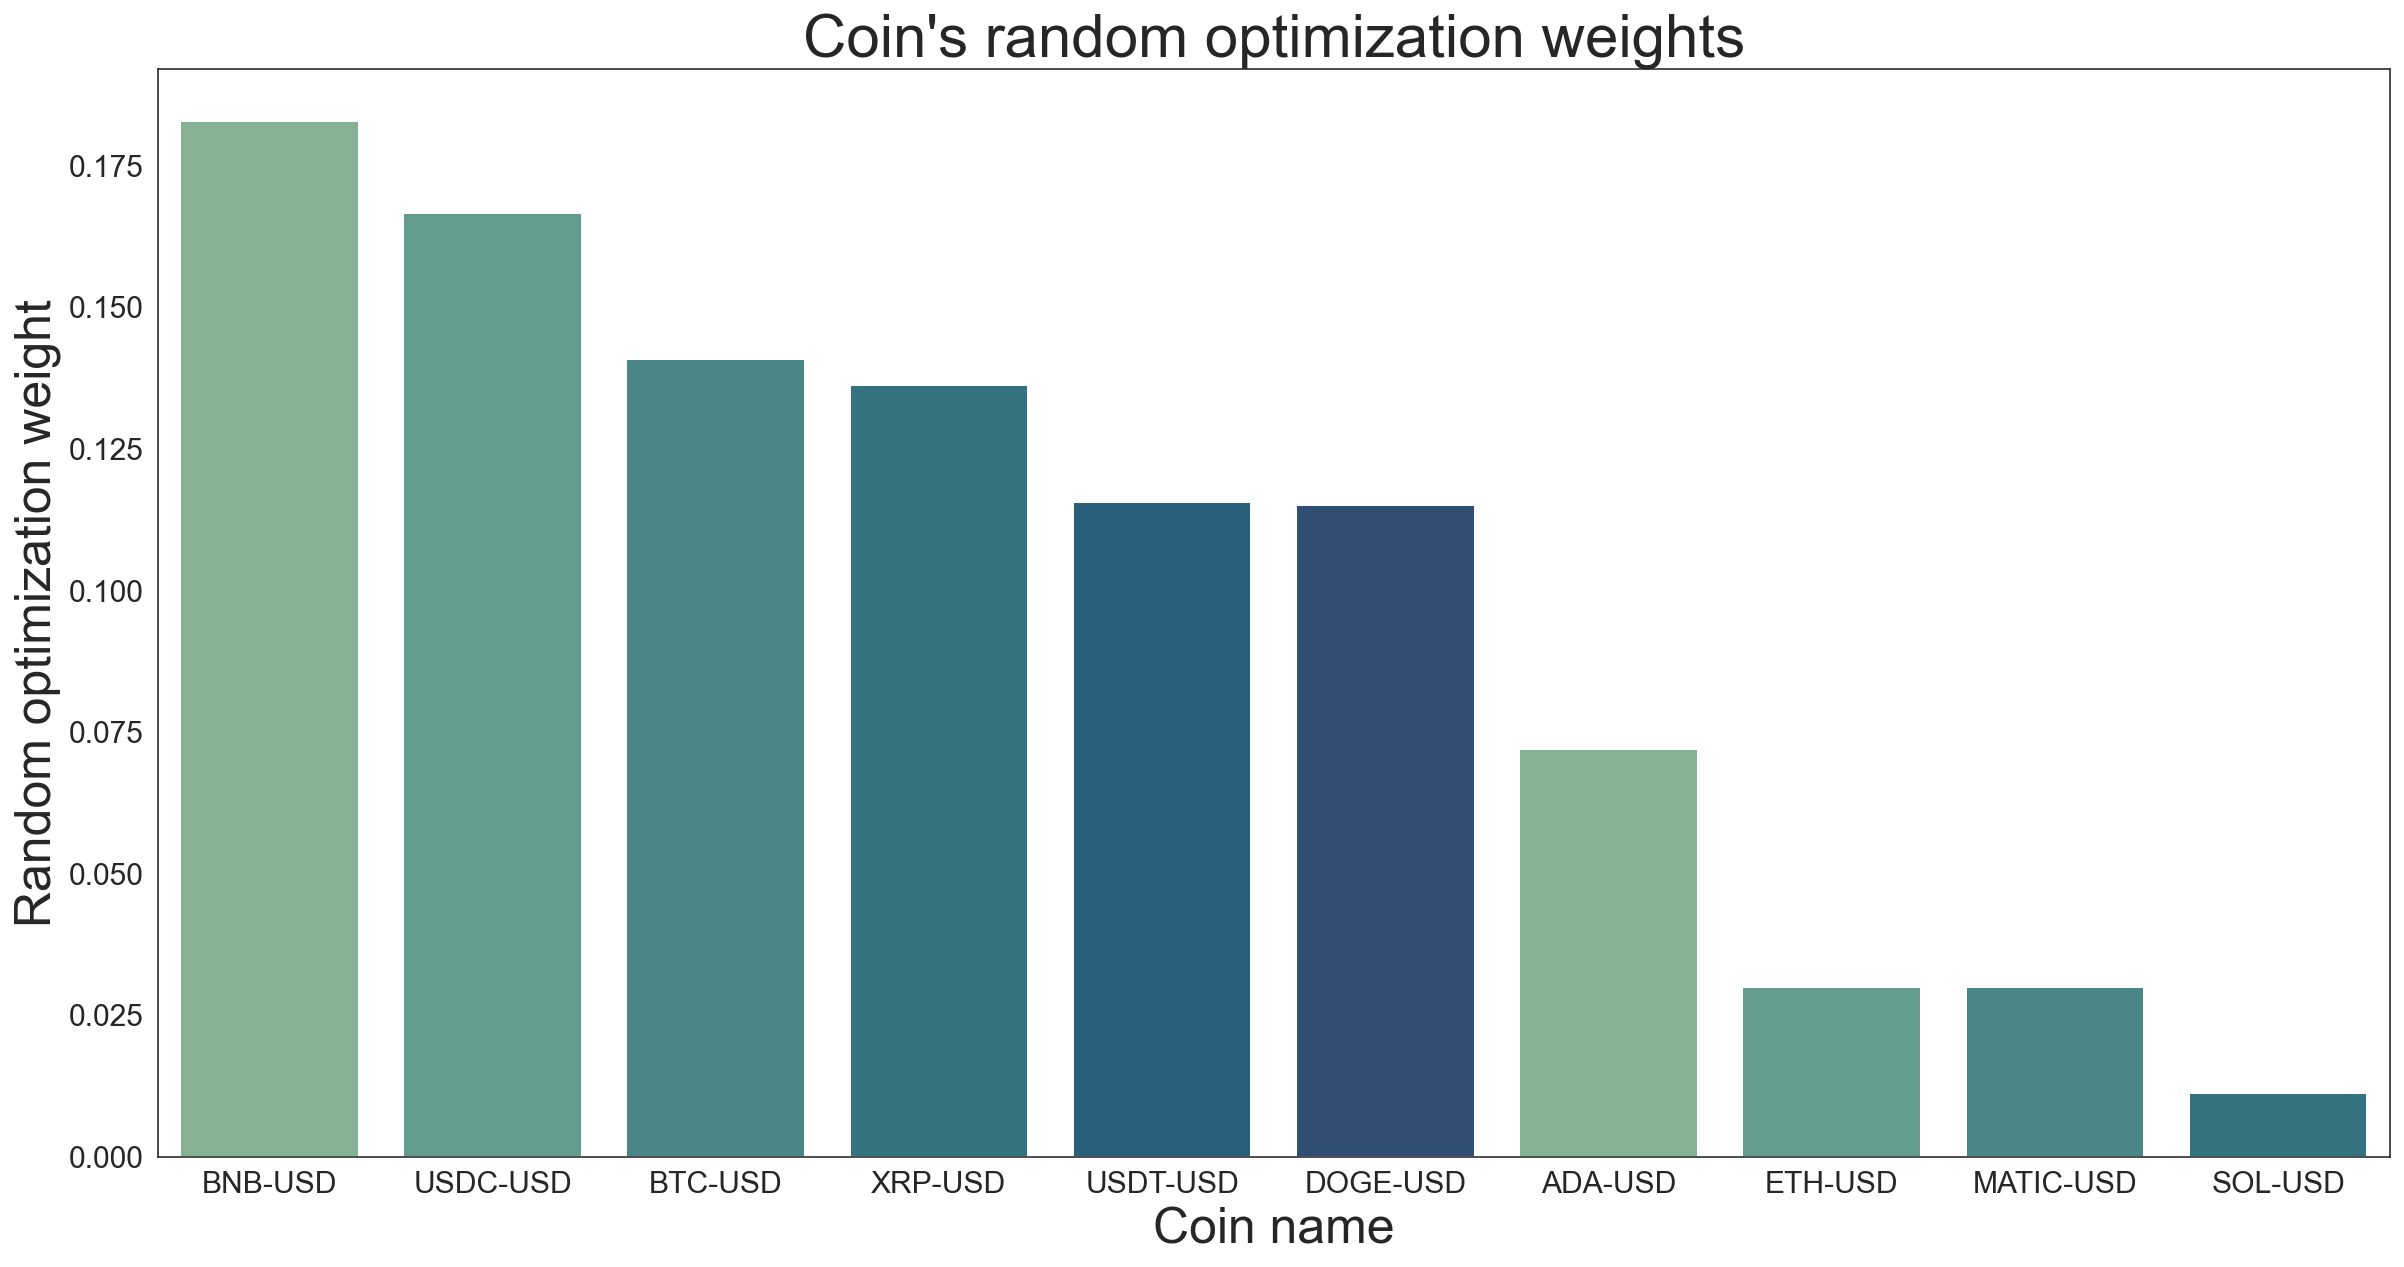

In [15]:
random_weights_df = pd.DataFrame(list(zip(tokens_USD, random_weights)), columns=['Coin', 'Weight'])
random_weights_df = random_weights_df.sort_values(by=['Weight'], ascending=False)
sns.barplot(data=random_weights_df, x='Coin', y='Weight', palette=sns.color_palette("crest"))
plt.xlabel("Coin name", fontsize = 25)
plt.ylabel("Random optimization weight", fontsize = 25)
plt.title("Coin's random optimization weights", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

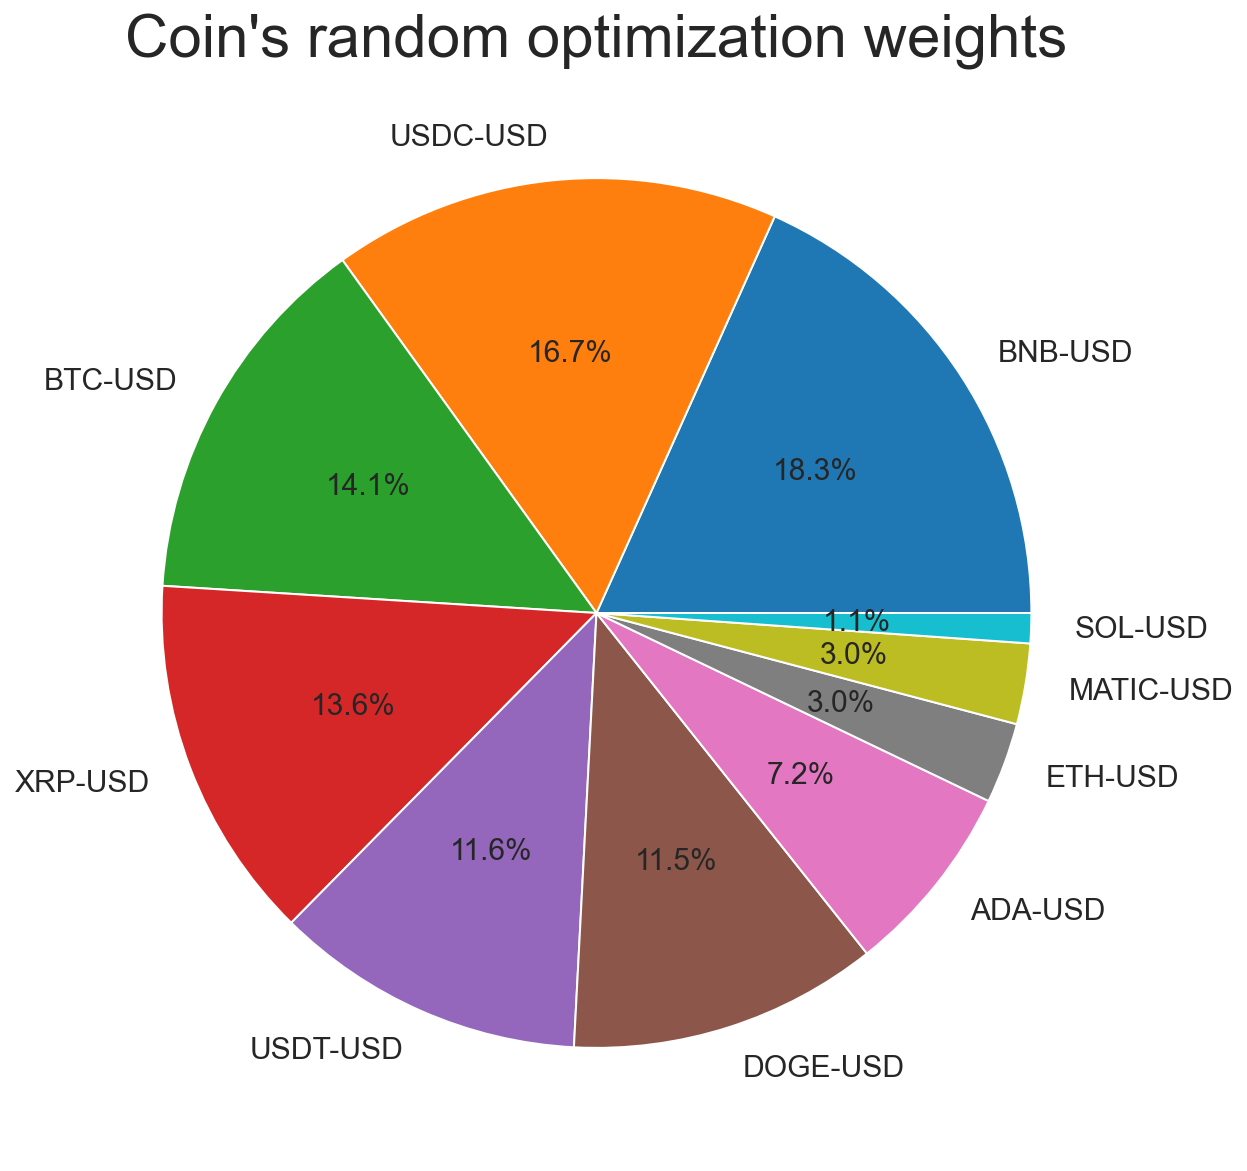

In [16]:
plt.pie(data=random_weights_df[random_weights_df['Weight'] > 0.01], x = 'Weight', labels ='Coin', autopct='%1.1f%%', textprops={'fontsize':15})
plt.title("Coin's random optimization weights", fontsize = 30)
plt.show()

### Finally, let's compare profit of our portfolio with a profit of a random portfolio. ###

In [17]:
random_portfolio_values = [start_portfolio_value]
today_value = 0
for _, row in prices_df.iterrows():
    for token in tokens:
        today_value += row[token] * (random_weights_dict[token + '-USD'] * start_portfolio_value / start_prices[token])
    random_portfolio_values.append(today_value)
    today_value = 0

final_random_portfolio_value = random_portfolio_values[-1]
random_portfolio_change = (final_random_portfolio_value - start_portfolio_value)
random_relative_portfolio_change = random_portfolio_change / start_portfolio_value * 100
print("Final random portfolio value = %.3f" % final_random_portfolio_value, sep="")
print("Final random portfolio change = %.3f" % random_portfolio_change, sep="")
print("Final random porfolio change = %.3f" % random_relative_portfolio_change , '%', sep ="")

Final random portfolio value = 10300.167
Final random portfolio change = 300.167
Final random porfolio change = 3.002%


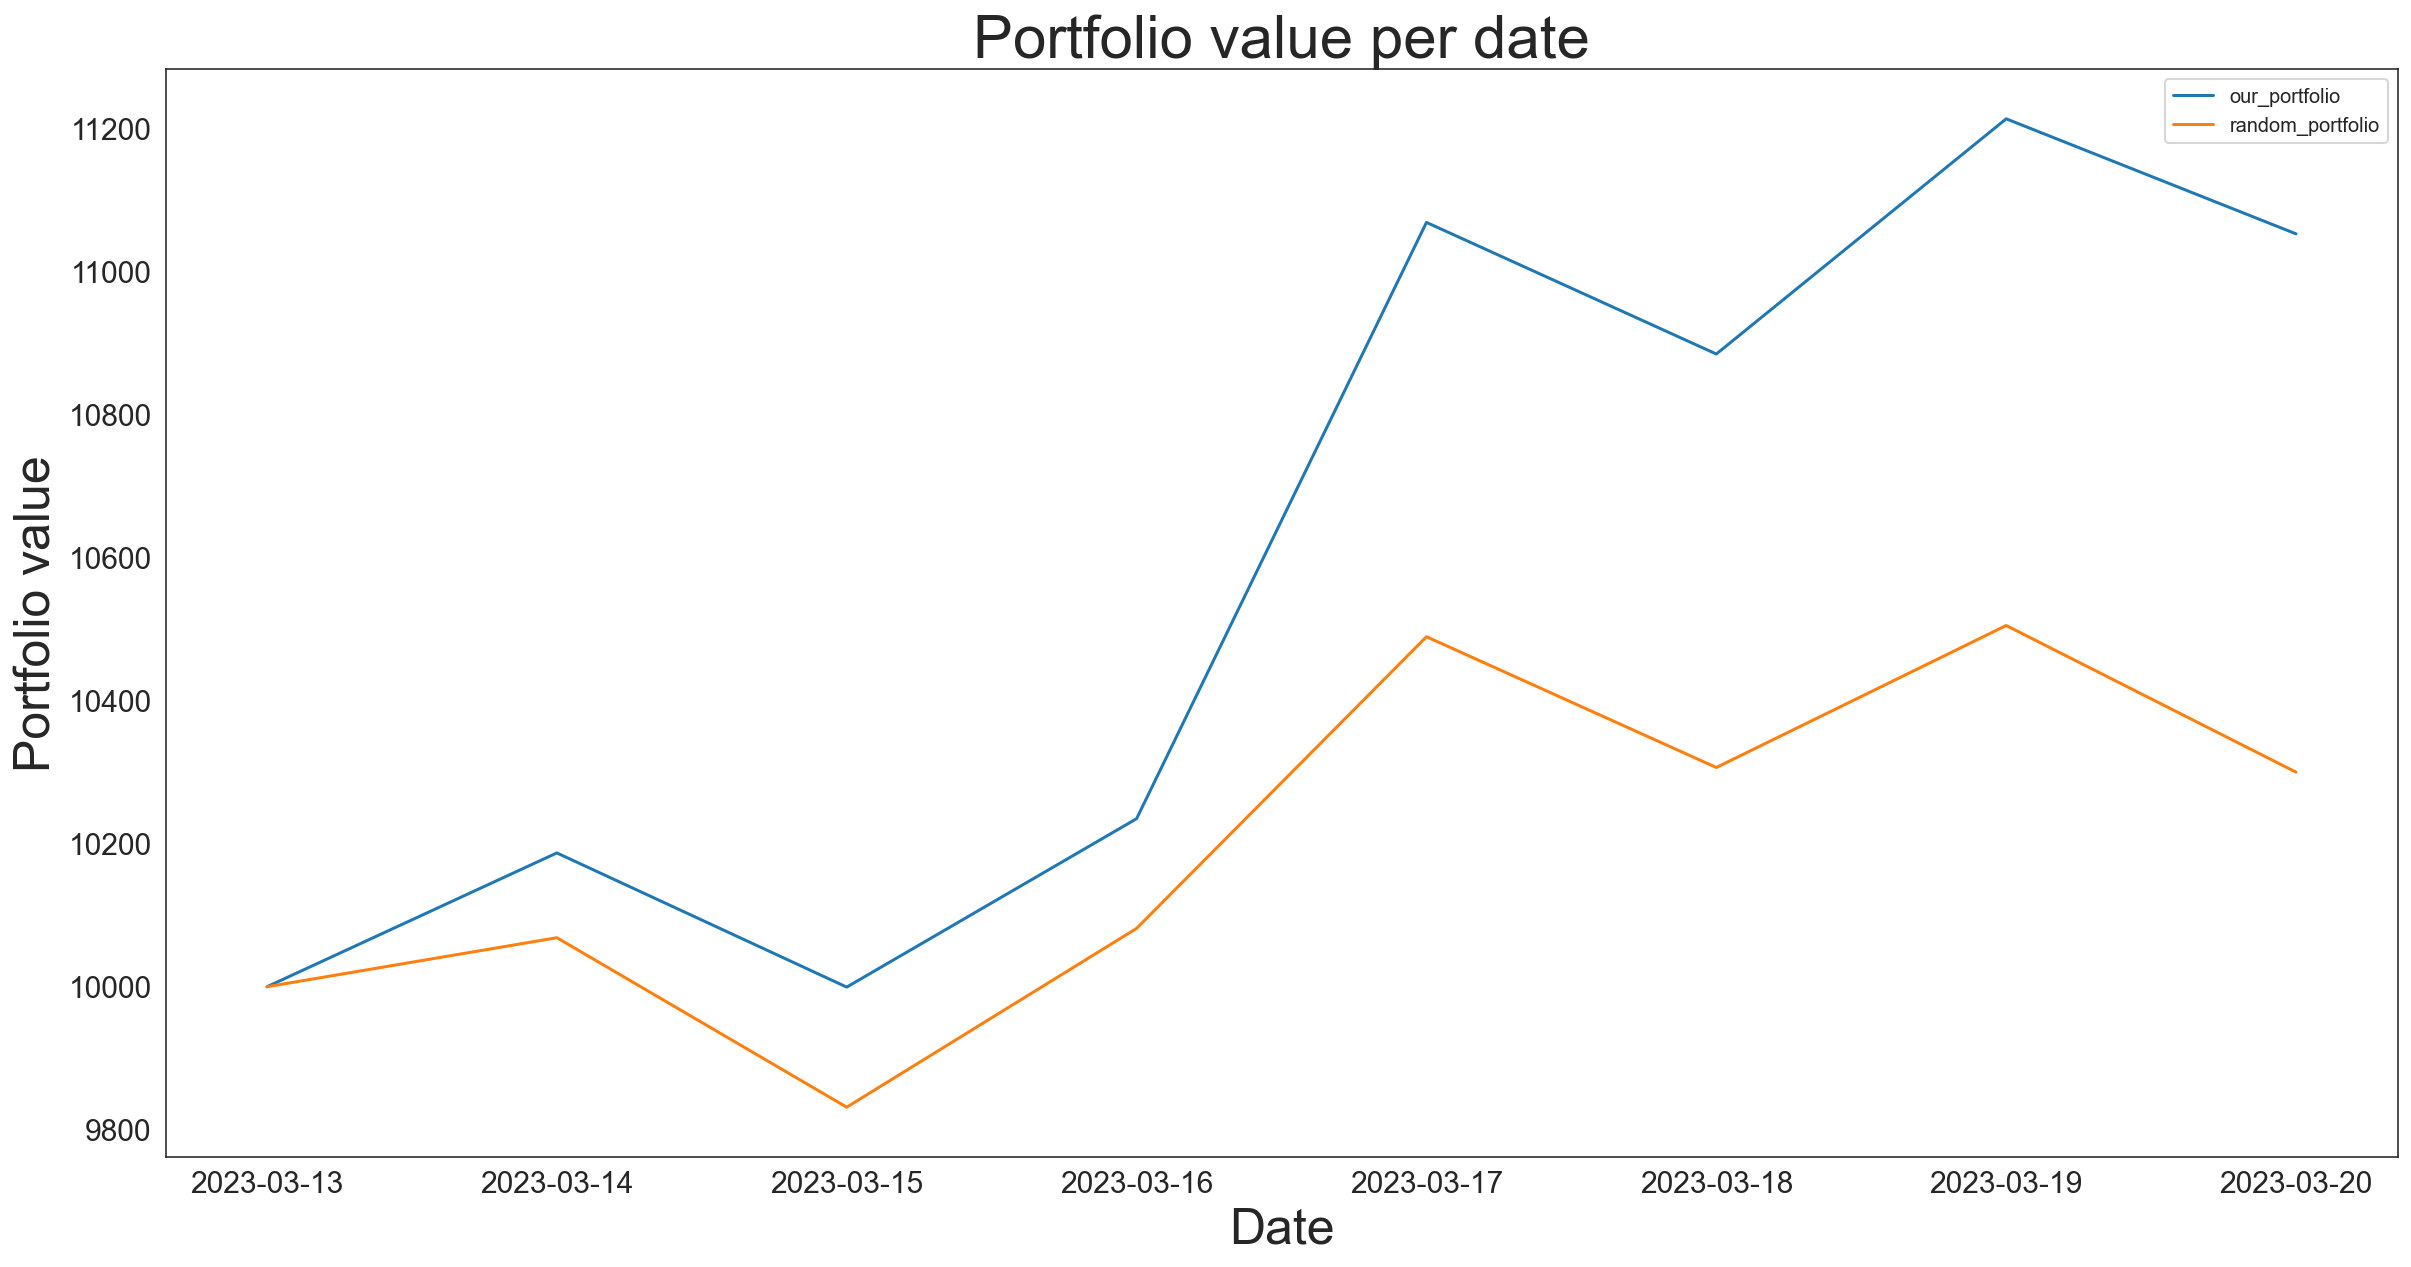

Our portfolio is better than a mean random portfolio on 753.060


In [18]:
plt.plot(dates, portfolio_values, label = 'our_portfolio')
plt.plot(dates, random_portfolio_values, label = 'random_portfolio')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Portfolio value", fontsize = 25)
plt.title("Portfolio value per date", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()
print("Our portfolio is better than a mean random portfolio on %.3f" % (final_portfolio_value - final_random_portfolio_value), sep="")

In [19]:
n_portfolios = 1000
final_random_portfolio_values = []
np.random.seed(42)

for i in range(n_portfolios):
    random_weights = np.random.rand(len(tokens))
    random_weights = np.random.rand(len(tokens))
    random_weights /= random_weights.sum()
    random_weights = list(map(lambda x: np.round(x, 5), random_weights))
    random_weights_dict = {}
    i = 0
    for token in tokens_USD:
        random_weights_dict[token] = random_weights[i]
        i += 1
    
    random_portfolio_values = [start_portfolio_value]
    today_value = 0
    for _, row in prices_df.iterrows():
        for token in tokens:
            today_value += row[token] * (random_weights_dict[token + '-USD'] * start_portfolio_value / start_prices[token])
        random_portfolio_values.append(today_value)
        today_value = 0
    
    final_random_portfolio_values.append(random_portfolio_values[-1])

diff = final_random_portfolio_values - final_portfolio_value
print("Mean final random portfolio value = %.3f" % np.mean(final_random_portfolio_values), sep ="")
print("Our portfolio is better than a mean random portfolio on %.3f" % (final_portfolio_value - np.mean(final_random_portfolio_values)), sep="")
print(f"Our portfolio is better in {np.count_nonzero(diff < 0)}/{n_portfolios} ({np.round(np.count_nonzero(diff < 0) / n_portfolios * 100, 3)}%) cases")

Mean final random portfolio value = 10209.118
Our portfolio is better than a mean random portfolio on 844.108
Our portfolio is better in 1000/1000 (100.0%) cases
